<center><h1>Titanic Use Case</h1></center><br>

<img src="https://titanichistoricalsociety.org/wp-content/uploads/2017/09/titanic_historical_society_homepage_harley_crossley.jpg" alt="TitanicShip">

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

This is a binary classification problem where we need to predict whether passengers are likely to survive or not.<br>
We also need to understand what variables contribute the most to a passenger's survival.

<h2 style="color: green">Acquisition</h2>

Lets begin by loading our datasets and taking a look at them.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

passenger_train_path = "/Users/karimafifi/Desktop/Titanic/train.csv"
passenger_test_path = "/Users/karimafifi/Desktop/Titanic/test.csv"
passenger_test_target_path = "/Users/karimafifi/Desktop/Titanic/gender_submission.csv"
passenger_train_df = pd.read_csv(passenger_train_path)
passenger_test_df = pd.read_csv(passenger_test_path)
passenger_test_target_df = pd.read_csv(passenger_test_target_path)

In [2]:
print("passenger_train_df shape: {0}".format(passenger_train_df.shape))
print("passenger_test_df shape: {0}".format(passenger_test_df.shape))
print("passenger_test_target_df shape: {0}".format(passenger_test_target_df.shape))

passenger_train_df shape: (891, 12)
passenger_test_df shape: (418, 11)
passenger_test_target_df shape: (418, 2)


In [3]:
passenger_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
passenger_test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
passenger_test_target_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<h2 style="color: green">Exploration & Preparation</h2>

The passenger_test_target_df is the target variable for our testset. We will merge the two dataframes for ease of use.

In [6]:
passenger_test_df = pd.merge(passenger_test_df, passenger_test_target_df, how='left', left_on=['PassengerId'], right_on=['PassengerId'])

In [7]:
passenger_test_df.shape

(418, 12)

In [8]:
passenger_df=pd.concat([passenger_train_df, passenger_test_df], axis=0)
passenger_df.shape

(1309, 12)

We need to set the PassengerId column as index.

In [9]:
passenger_df.set_index(['PassengerId'], drop=True, inplace=True)
passenger_train_df.set_index(['PassengerId'], drop=True, inplace=True)
passenger_test_df.set_index(['PassengerId'], drop=True, inplace=True)

Now, we need to make sure that our variables have the right datatypes.

In [10]:
passenger_df.dtypes

Age         float64
Cabin        object
Embarked     object
Fare        float64
Name         object
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
Survived      int64
Ticket       object
dtype: object

In [11]:
passenger_df.nunique()

Age           98
Cabin        186
Embarked       3
Fare         281
Name        1307
Parch          8
Pclass         3
Sex            2
SibSp          7
Survived       2
Ticket       929
dtype: int64

In [12]:
passenger_df['Survived'] = passenger_df['Survived'].astype('object')
passenger_df['Pclass'] = passenger_df['Pclass'].astype('object')

Lets extract the Title of each passenger from the Name var as it might be useful in our analysis. We will then drop the Name column as it has no use for us.

In [13]:
passenger_df['Title']=passenger_df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
passenger_df.drop(['Name'], axis=1, inplace=True)

Lets now identify any missing values in our dataset.

In [14]:
passenger_df.isnull().values.any()

True

In [15]:
passenger_df_na = passenger_df.isnull()
passenger_df_na.name = "Passengers Data NA"
for column in passenger_df_na.columns.values.tolist():
    print(column)
    print(passenger_df_na[column].value_counts())
    print('')

Age
False    1046
True      263
Name: Age, dtype: int64

Cabin
True     1014
False     295
Name: Cabin, dtype: int64

Embarked
False    1307
True        2
Name: Embarked, dtype: int64

Fare
False    1308
True        1
Name: Fare, dtype: int64

Parch
False    1309
Name: Parch, dtype: int64

Pclass
False    1309
Name: Pclass, dtype: int64

Sex
False    1309
Name: Sex, dtype: int64

SibSp
False    1309
Name: SibSp, dtype: int64

Survived
False    1309
Name: Survived, dtype: int64

Ticket
False    1309
Name: Ticket, dtype: int64

Title
False    1309
Name: Title, dtype: int64



We have missing values in Age, Cabin, Embarked and Fare. We have more missing data in Cabin than available data and it is not possible to accurately predict the missing values for Cabin while having that precentage of missing values so, we are not going to include that column in our predictions.

In [16]:
passenger_df.drop(['Cabin'], axis=1, inplace=True)

Lets replace the missing values of Embarked with the mode.

In [17]:
embarked_mode=passenger_df['Embarked'].mode()
passenger_df['Embarked'].replace(np.nan, embarked_mode[0], inplace=True)

We will replace the missing values for Fare with the median according to the Pclass of passengers. We will use the median since the mean will get pulled by outliers, if they exist. A passenger with a higher ticket class, is likely to pay more.

In [18]:
pclasses=passenger_df['Pclass'].unique()
class_medians = dict()
for pclass in pclasses:
    median=passenger_df[passenger_df['Pclass']==pclass]['Fare'].median()
    class_medians[pclass]=median

for index, row in passenger_df.iterrows():
    if np.isnan(row['Fare']):
        passenger_df.at[index, 'Fare']=class_medians[row['Pclass']]

We will now replace the missing values for Age with the median value according to the Title of passengers. Passengers with a Mrs Title are more likely to be older than passengers with a Miss Title.

In [19]:
titles=passenger_df['Title'].unique()
title_medians = dict()
for title in titles:
    median=passenger_df[passenger_df['Title']==title]['Age'].median()
    title_medians[title]=median

for index, row in passenger_df.iterrows():
    if np.isnan(row['Age']):
        passenger_df.at[index, 'Age']=title_medians[row['Title']]

Lets make use of the Ticket column by extracting the prefix of each ticket. Passengers with the same ticket prefix might have faced the same conditions when the liner was drowning.

In [20]:
def get_ticket_prefix(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'MISSING'

passenger_df['Ticket'] = passenger_df['Ticket'].map(get_ticket_prefix)

We will create a new feature to entail the size of each member's family on board. The size of the family will include the passenger thyself. After creating the new feature, we will create another feature that bins the size of each member's family into a singleton or a small family or a large family on board. Members of larger families are less likely to survive as they will probably spend more time checking on each other and making sure that each family member is fine.

In [21]:
passenger_df['FamilySize'] = passenger_df['SibSp'] + passenger_df['Parch'] + 1
passenger_df['FamilySizeCategory'] = passenger_df['FamilySize'].map(lambda size: 'Singleton' if size==1 else('SmallFamily' if 2<=size<=4 else('LargeFamily' if 5<=size else 0)))


Since we have done dealing with missing values and creating new features, we will now determine the features with a significant effect on the target variable using ANOVA and Chi-squared tests.

In [22]:
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

chi_f_values=[]
variables=[]

for column in passenger_df.columns.values.tolist():
    if column != 'Survived':
        if passenger_df[column].dtype=='object':
            ct1=pd.crosstab(passenger_df[column], passenger_df['Survived'])
            colsum=ct1.sum(axis=0)
            colpct=ct1/colsum
            cs1=chi2_contingency(ct1)
            variables.append(column)
            chi_f_values.append(cs1[0])
            print("Chi-Squared results for {0}: Chi-square value={1}, P-value={2}".format(column, cs1[0], cs1[1]))
        else:
            grouped_test=passenger_df[['Survived', column]].groupby(['Survived'])
            f_val, p_val = f_oneway(grouped_test.get_group(0)[column], grouped_test.get_group(1)[column])
            variables.append(column)
            chi_f_values.append(f_val)
            print("ANOVA results for {0}: F-score={1}, P-value={2}".format(column, f_val, p_val))

ANOVA results for Age: F-score=2.8491291441408553, P-value=0.09166202195520894
Chi-Squared results for Embarked: Chi-square value=24.19377595554332, P-value=5.5768415194448465e-06
ANOVA results for Fare: F-score=75.60045961211392, P-value=1.023416341843774e-17
ANOVA results for Parch: F-score=15.69159420522941, P-value=7.857864292721364e-05
Chi-Squared results for Pclass: Chi-square value=91.72367559290262, P-value=1.2090852275863937e-20
Chi-Squared results for Sex: Chi-square value=617.3133522952658, P-value=2.871410444001617e-136
ANOVA results for SibSp: F-score=0.007343501174659599, P-value=0.9317226134341012
Chi-Squared results for Ticket: Chi-square value=73.19081289921012, P-value=0.00024496176438461564
Chi-Squared results for Title: Chi-square value=646.2675706380724, P-value=2.2290520272561057e-126
ANOVA results for FamilySize: F-score=4.89604844293584, P-value=0.027090526663826407
Chi-Squared results for FamilySizeCategory: Chi-square value=95.43687481029842, P-value=1.8886259

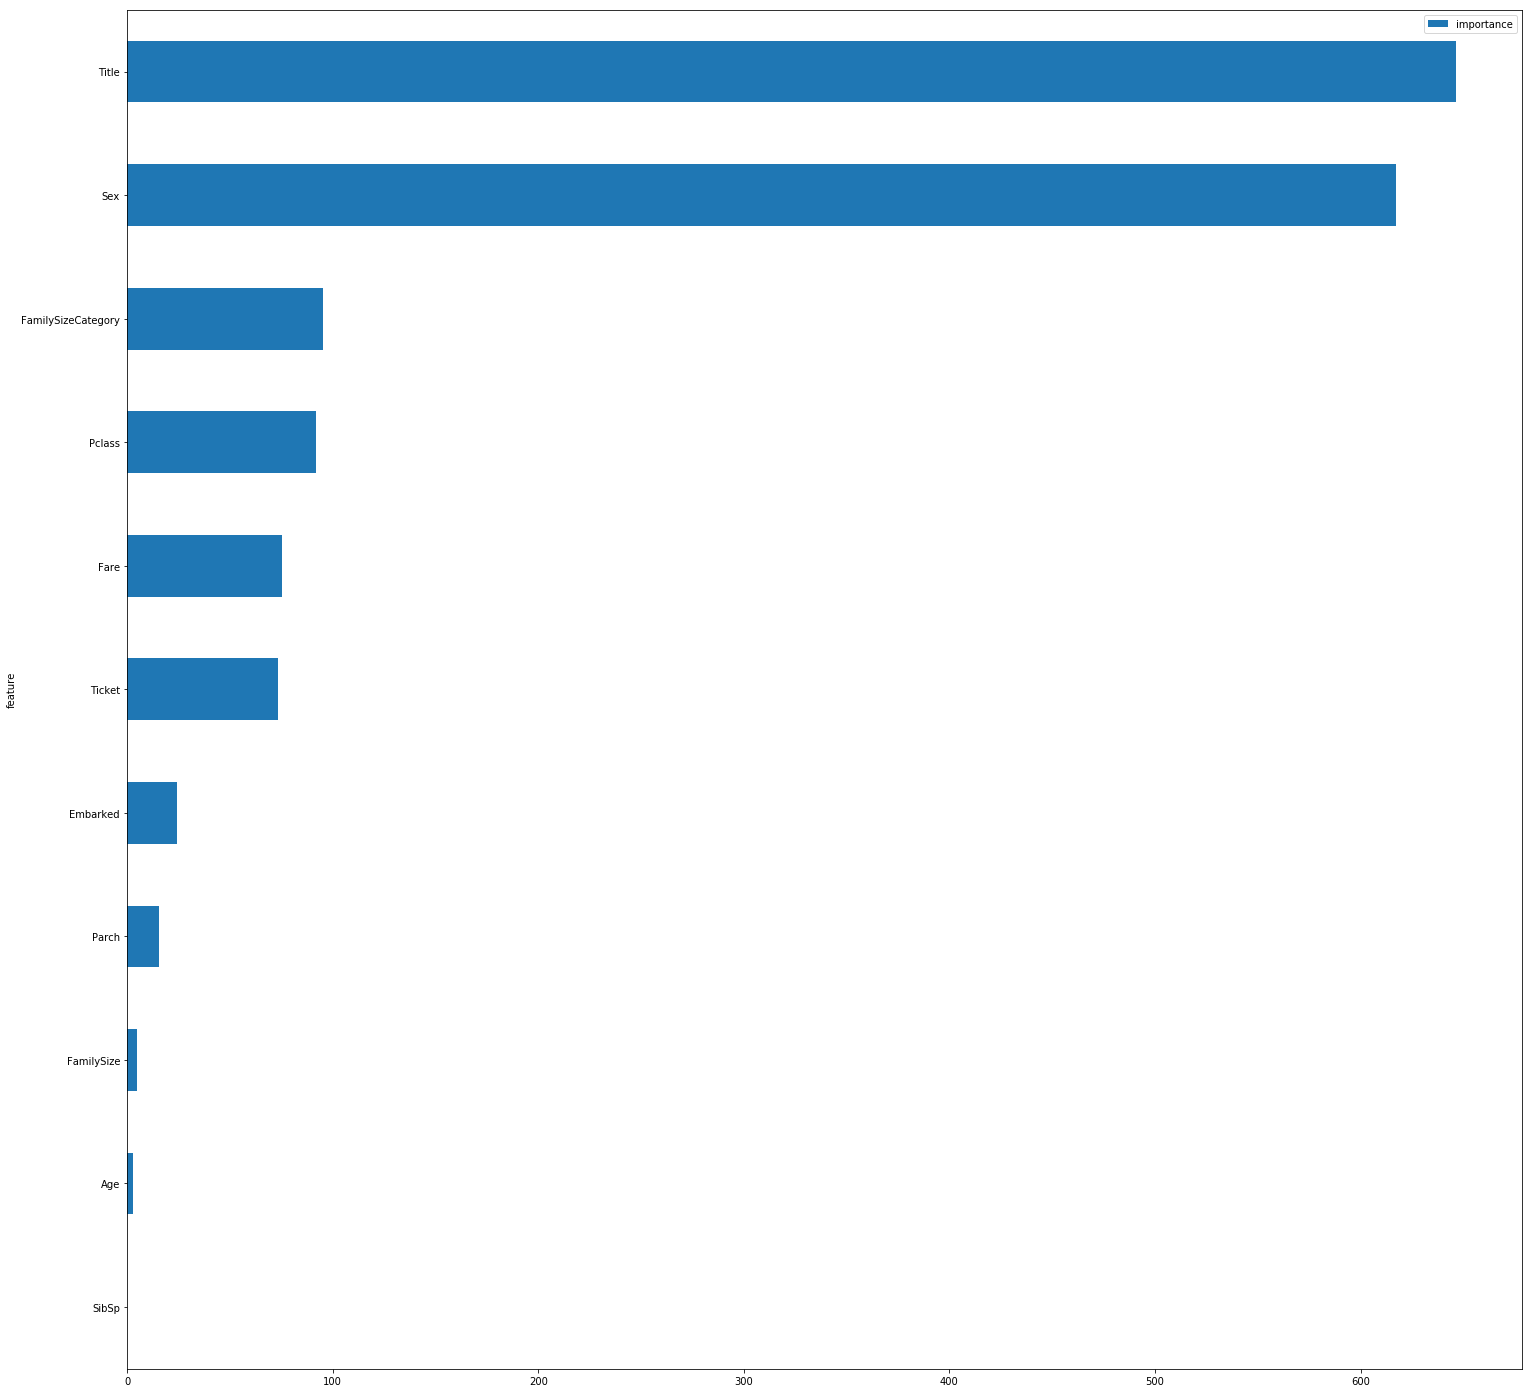

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

features=pd.DataFrame()
features['feature'] = variables
features['importance'] = chi_f_values
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

As we can see, Title, Sex, Pclass, FamilySizeCategory, Fare, Ticket and Embarked are important features to consider.

Lets now confirm our findings and derive more insights.

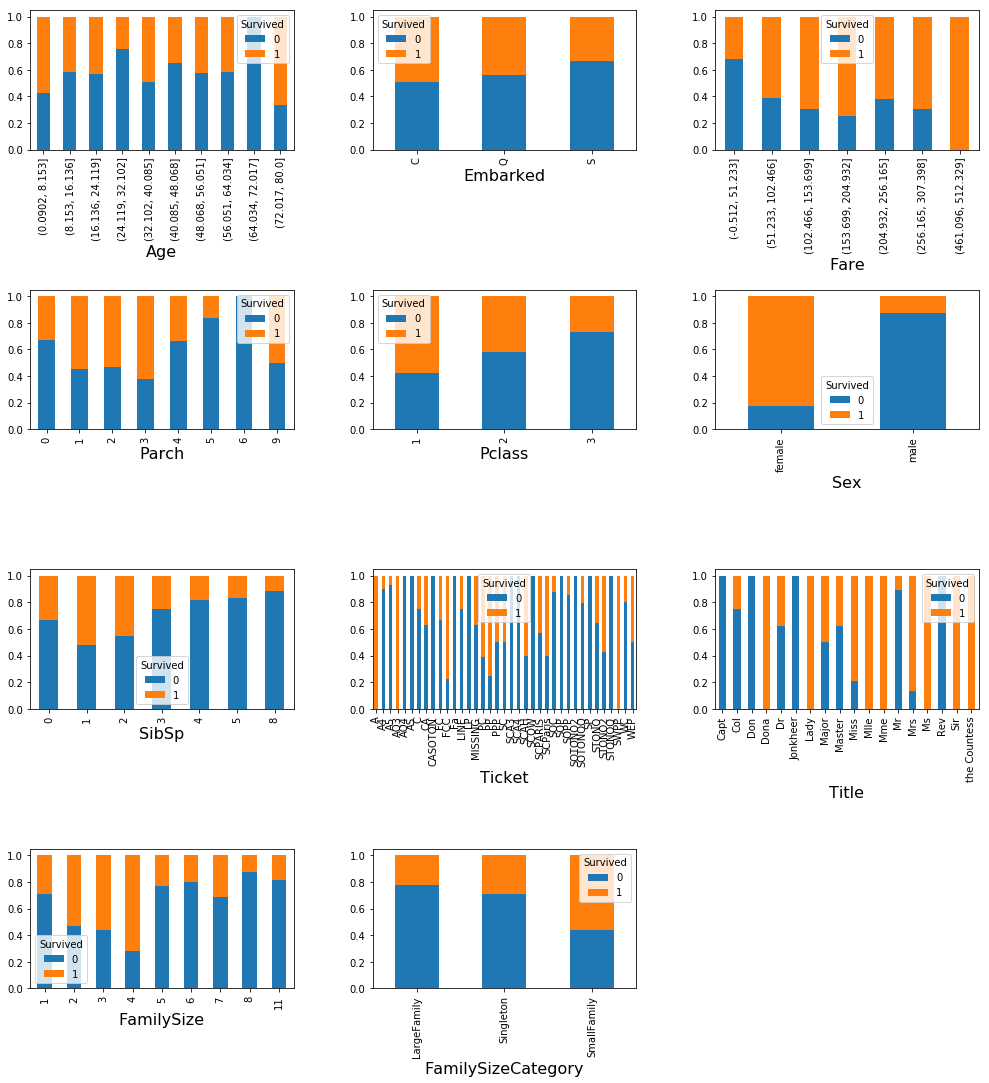

In [24]:
fig = plt.figure(figsize=(17,18))
i = 1
for column in passenger_df.columns.values.tolist():
    if column != 'Survived':
        axes = fig.add_subplot(4, 3, i)
        if column == 'Age':
            age_binned=pd.cut(passenger_df['Age'], 10)
            age_binned.sort_values(inplace=True)
            table= pd.crosstab(age_binned, passenger_df['Survived'])
        elif column == 'Fare':
            fare_binned=pd.cut(passenger_df['Fare'], 10)
            fare_binned.sort_values(inplace=True)
            table= pd.crosstab(fare_binned, passenger_df['Survived'])
        else:
            table= pd.crosstab(passenger_df[column], passenger_df['Survived'])
        plt.subplots_adjust(wspace = 0.3, hspace = 1.0)
        plt.xlabel(column, fontsize=16)
        plt.grid()
        table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axes)
        i+=1    

Passengers with a higher ticket class, had a higher survival rate.<br>
Females had a much higher survival rate. This is because of other Passengers' efforts to save the females.<br>
Young children had a little higher survival rate. This is probably because of other Passengers' efforts to save the children. The same thing applies for the eldery which had a high survival rate.<br>
Passengers Embarked from 'Cherbourg' had the highest survival rate, followed by 'Queenstown', then 'Southampton'.<br>
Passengers with female titles followed by upper-class titles, had a higher survival rate.<br>
Passengers with a small family on board had the highest survival rate, followed by Singleton, followed by passengers with a large family on board.

We need to normalize our numerical values using z-score before going further.

In [25]:
for column in passenger_df.columns.values.tolist():
    if passenger_df[column].dtype != 'object':
        passenger_df[column]=(passenger_df[column] - passenger_df[column].mean())/passenger_df[column].std(ddof=0)

We will now create dummy variables for our categorical variables

In [26]:
for column in passenger_df.columns.values.tolist():
    if column != 'Survived':
        if passenger_df[column].dtype=='object':
            dummies=pd.get_dummies(passenger_df[column], prefix=column)
            passenger_df = pd.concat([passenger_df, dummies], axis=1)
            passenger_df.drop(column, axis=1, inplace=True)

Lets separate our features and our target variable

In [27]:
passenger_df_xs = passenger_df.drop('Survived', axis=1)
passenger_df_y = pd.DataFrame(passenger_df['Survived'])

Lets take a look at the count of our class labels.

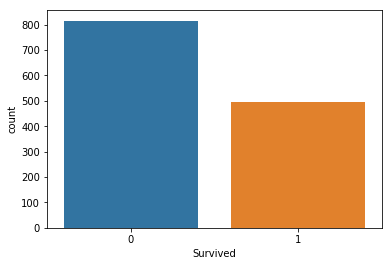

In [28]:
sns.countplot(passenger_df['Survived'])

The data is biased towards the class label '0' but we will leave it as it is as we have a small number of observations.

At last, lets get our test set back after finishing preparation.

In [29]:
passenger_train_df_xs=passenger_df_xs.loc()[list(passenger_train_df.index.values), :]
passenger_train_df_y=passenger_df_y.loc()[list(passenger_train_df.index.values), :]
passenger_test_df_xs=passenger_df_xs.loc()[list(passenger_test_df.index.values), :]
passenger_test_df_y=passenger_df_y.loc()[list(passenger_test_df.index.values), :]

<h2 style="color: green">Modeling</h2>

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Lets use XGBOOST to get only the important features after creating the dummy variables to include in our final model. We will use only the training set as using the test set will be considered cheating ;)

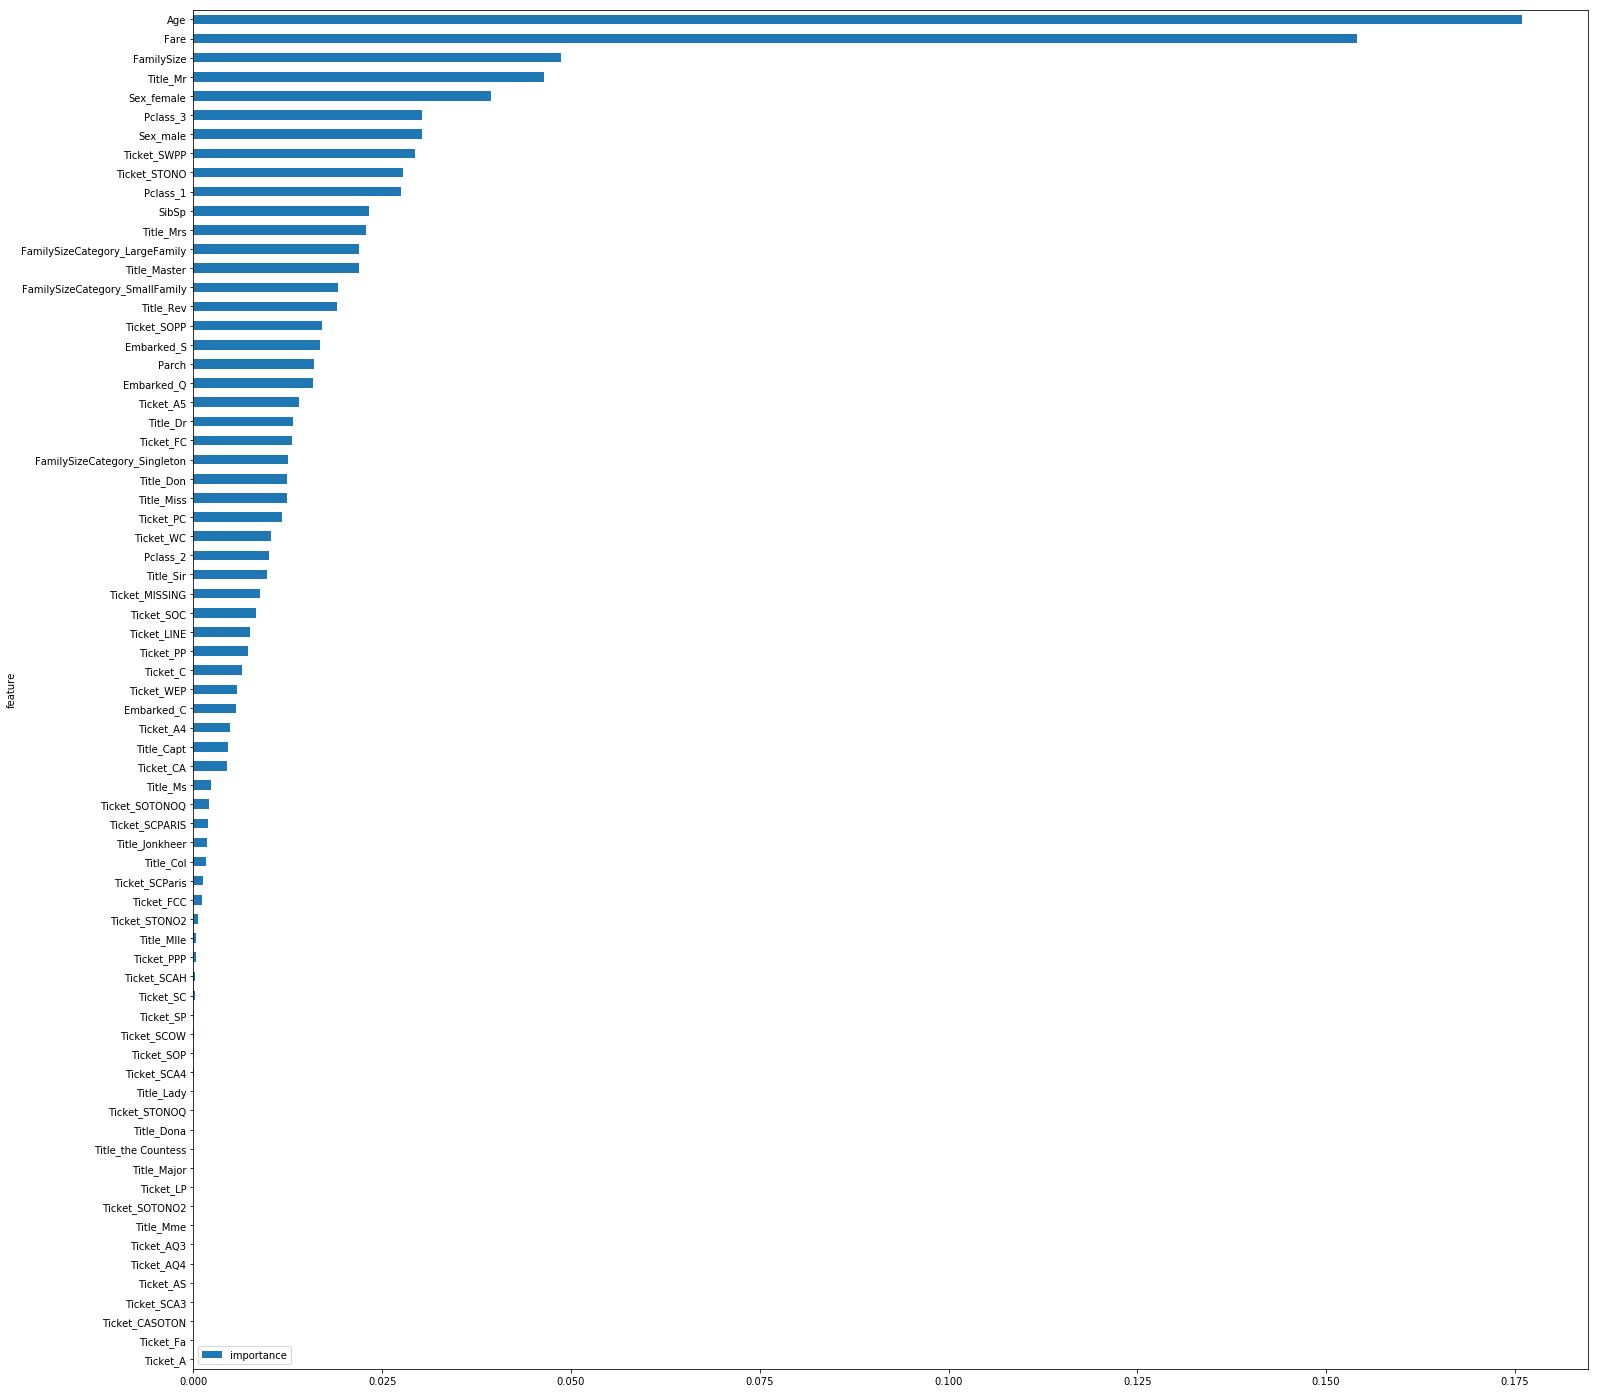

In [36]:
warnings.filterwarnings("ignore")

xgboost = GradientBoostingClassifier(n_estimators=200, max_features='sqrt')
xgboost_model = xgboost.fit(passenger_train_df_xs, passenger_train_df_y.astype('int'))
features = pd.DataFrame()
features['feature'] = passenger_train_df_xs.columns
features['importance'] = xgboost_model.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(25, 25))

In [37]:
print(passenger_train_df_xs.shape)
print(passenger_test_df_xs.shape)
model = SelectFromModel(xgboost_model, prefit=True)
train_reduced_xs = pd.DataFrame(model.transform(passenger_train_df_xs))
print(train_reduced_xs.shape)
test_reduced_xs=pd.DataFrame(model.transform(passenger_test_df_xs))
print(test_reduced_xs.shape)

(891, 71)
(418, 71)
(891, 20)
(418, 20)


We will test multiple ML algorithms using cross validation and determine the one with the best classification accuracy even though, the target class labels are biased but classification accuracy is the metric used on the leaderboard on Kaggle.

In [38]:
log_reg = LogisticRegression()
log_reg_cv = LogisticRegressionCV()
svm_rbf_cv = SVC(kernel='rbf', max_iter=200)
svm_linear_cv = SVC(kernel='linear', max_iter=200)
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt')
g_boost = GradientBoostingClassifier(n_estimators=500, max_features='sqrt')

models = [log_reg, log_reg_cv, svm_rbf_cv, svm_linear_cv, rf, g_boost]

In [39]:
warnings.filterwarnings("ignore")

for model in models:
    xval = cross_val_score(model, passenger_train_df_xs, passenger_train_df_y.astype('int'), cv = 5, scoring='accuracy')
    print('CV score of {0} = {1}'.format(model.__class__, np.mean(xval)))
    print('-----------')

CV score of <class 'sklearn.linear_model.logistic.LogisticRegression'> = 0.8227023885137423
-----------
CV score of <class 'sklearn.linear_model.logistic.LogisticRegressionCV'> = 0.8249495795249784
-----------
CV score of <class 'sklearn.svm.classes.SVC'> = 0.831672392276438
-----------
CV score of <class 'sklearn.svm.classes.SVC'> = 0.7553730476805518
-----------
CV score of <class 'sklearn.ensemble.forest.RandomForestClassifier'> = 0.8126084346087135
-----------
CV score of <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> = 0.8328399272711025
-----------


The classification accuracy of some of our models are very close. We are going to use GradientBoostingClassifier as it has way too parameters to tune and it has a better chance to give a better classification accuracy score. Lets use GridSearchCV to tune our parameters.

In [40]:
param_grid = {'n_estimators': [100, 300, 400, 500], 'max_depth' : [4, 6, 8, 10], 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 6, 10], 'min_samples_leaf': [1, 3, 6, 10]}

xgboost = GradientBoostingClassifier()
cross_validation = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(xgboost, param_grid=param_grid, scoring='accuracy', cv=cross_validation, n_jobs=-1)

xgboost_model = grid_search.fit(passenger_train_df_xs, passenger_train_df_y.astype('int'))
xgboost_parameters = grid_search.best_params_

print('Optimal score: {0}'.format(grid_search.best_score_))
print('Optimal parameters: {0}'.format(grid_search.best_params_))

Optimal score: 0.8428731762065096
Optimal parameters: {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}


In [41]:
xgboost_model = GradientBoostingClassifier(**xgboost_parameters)
xgboost_model.fit(passenger_train_df_xs, passenger_train_df_y.astype('int'))
prediction=xgboost_model.predict(passenger_test_df_xs)
out_df=pd.DataFrame(data={'PassengerId': passenger_test_df_xs.index.values, 'Survived': prediction})
out_df.set_index(['PassengerId'], drop=True, inplace=True)
out_df.to_csv('titanic_predictions.csv')